In [ ]:
from keras.layers import Lambda, Input, Dense, BatchNormalization, LeakyReLU, GlobalAveragePooling2D, Activation, Conv2D, Conv2DTranspose, Flatten, Dense, Reshape
from keras.models import Model
from keras.datasets import mnist
from keras.losses import mse, binary_crossentropy
from keras.utils import plot_model
from keras import backend as K
from keras.models import load_model

import numpy as np
import matplotlib.pyplot as plt
import os
# Main cell to run
from google.colab import drive
drive.mount('/content/drive')

Using TensorFlow backend.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#### HELPER FUNCTIONS
import cv2
import glob, os
import pandas as pd
from PIL import Image
import numpy as np

import imageio
def read_imgs_to_np_from_folder(img_folder):
  cwd = os.getcwd()

  # os.chdir(img_folder + '/')

  imgs = glob.glob(img_folder + '*.jpg')
  # height,width = imageio.imread(imgs[0]).shape[:2]

  X = []
  count = 0
  for f in imgs:
    x = imageio.imread(f)

    if len(x.shape) == 3 and x.shape[0] == 260 and x.shape[1] == 195 and x.shape[2] == 3:
      x = x.astype(np.float32) / 255.0
      X.append(x)
      del x
      count += 1
    if count % 3000 == 0:
      print("Traversed ", count)
    
  X = np.array(X)
  print(X.shape)
  return X

In [ ]:
!chmod 600 '/content/drive/My Drive/rerun/new_imgs6.tar.xz'
!cp '/content/drive/My Drive/rerun/new_imgs6.tar.xz' '/content/data_im/'
!tar -xf '/content/data_im/new_imgs6.tar.xz'

In [ ]:
# x_train = read_imgs_to_np_from_folder('/content/new_imgs4/')
cwd = os.getcwd()

# os.chdir(img_folder + '/')

imgs = glob.glob('/content/new_imgs6/' + '*.jpg')
# height,width = imageio.imread(imgs[0]).shape[:2]

x_train = []
count = 0
for f in imgs:
  x = imageio.imread(f)

  if len(x.shape) == 3 and x.shape[0] == 240 and x.shape[1] == 180 and x.shape[2] == 3:
    x = x.astype(np.float32) / 255.0
    x_train.append(x)
    del x
    count += 1
  if count % 3000 == 0:
    print("Traversed ", count)
  
x_train = np.array(x_train)

Traversed  3000
Traversed  6000
Traversed  9000
Traversed  12000
Traversed  15000
Traversed  18000
Traversed  21000


In [ ]:
!chmod 777 '/content/drive/My Drive/rerun/'













Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
encoder_input (InputLayer)      (None, 240, 180, 3)  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 120, 90, 16)  208         encoder_input[0][0]              
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 120, 90, 16)  64          conv2d_1[0][0]                   
__________________________________________________________________________________________________
leaky_re_lu_1 (LeakyReLU)       (None, 120, 90, 16)  0           batch_normalization_1[0][0]      
________________________________________________________________________________

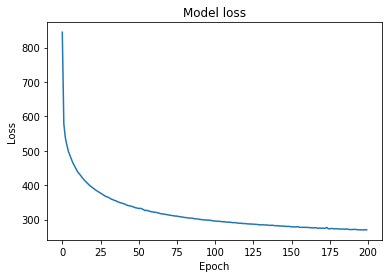

<Figure size 432x288 with 0 Axes>

In [ ]:
def sampling(args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(z_log_var / 2) * epsilon

z_dim = 16
kernel_size = 2
latent_dim = 16
filter_dims = [16, 32, 64]
filter_decoder = [64, 32, 16]
image_shape = (240, 180, 3)
epochs = 200
batch_size = 16
from keras import layers, initializers
from keras.layers import Dropout

inputs = Input(shape=image_shape, name='encoder_input')
x = inputs
for i in range(2):
  filters = filter_dims[i]
  x = Conv2D(filters=filters,
            kernel_size=kernel_size,
            strides=2,
            padding='same')(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(0.1)(x)

# shape info needed to build decoder model
shape = K.int_shape(x)

# generate latent vector Q(z|X)
x = Flatten()(x)
x = Dense(128)(x)
x = LeakyReLU(0.1)(x)
z_mean = Dense(latent_dim, name='z_mean')(x)
z_log_var = Dense(latent_dim, name='z_log_var',
      kernel_initializer=initializers.Constant(0),
      bias_initializer=initializers.Constant(0))(x)

# use reparameterization trick to push the sampling out as input
# note that "output_shape" isn't necessary with the TensorFlow backend
z = Lambda(sampling, output_shape=(latent_dim,), name='z')([z_mean, z_log_var])

# instantiate encoder model
encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
encoder.summary()
plot_model(encoder, to_file='vae_cnn_encoder.png', show_shapes=True)

# build decoder model
latent_inputs = Input(shape=(latent_dim,), name='z_sampling')
x = Dense(128)(latent_inputs)
x = LeakyReLU(0.1)(x)
x = Dense(shape[1] * shape[2] * shape[3])(x)
x = LeakyReLU(0.1)(x)
x = Reshape((shape[1], shape[2], shape[3]))(x)

for i in range(2):
  filters = filter_decoder[i]
  x = Conv2DTranspose(filters=filters,
                      kernel_size=kernel_size,
                      strides=2,
                      padding='same')(x)
  x = BatchNormalization()(x)
  x = LeakyReLU(0.1)(x)

outputs = Conv2DTranspose(filters=3,
                          kernel_size=kernel_size,
                          activation='sigmoid',
                          padding='same',
                          name='decoder_output')(x)

# instantiate decoder model
decoder = Model(latent_inputs, outputs, name='decoder')
decoder.summary()
plot_model(decoder, to_file='vae_cnn_decoder.png', show_shapes=True)

# instantiate VAE model
outputs = decoder(encoder(inputs)[2])
vae = Model(inputs, outputs, name='vae')
vae.summary()

reconstruction_loss = mse(K.flatten(inputs),
                                           K.flatten(outputs))

reconstruction_loss *= image_shape[0] * image_shape[1]
kl_loss = 1 + (z_log_var) - K.square(z_mean) - K.exp(z_log_var)
kl_loss = K.sum(kl_loss, axis=-1)
kl_loss *= -0.5
vae_loss = K.mean(reconstruction_loss + kl_loss)

# def vae_loss(y_true, y_pred):
#     """ Calculate loss = reconstruction loss + KL loss for each data in minibatch """
#     recon = K.sum(K.binary_crossentropy(y_true, y_pred))
#     kl = 0.5 * K.sum(K.exp(z_log_sigma) + K.square(z_mean) - 1. - z_log_sigma, axis=1)
#     return recon + kl
vae.add_loss(vae_loss)
vae.compile(optimizer='adam')

history = vae.fit(x_train,
            epochs=epochs,
            batch_size=batch_size,
            verbose=1)
vae.save('/content/drive/My Drive/rerun/vae_binary_cross_adam_epoch_only_relu_200.h5')
encoder.save('/content/drive/My Drive/rerun/encoder_binary_cross_adam_epoch_only_relu_200.h5')
decoder.save('/content/drive/My Drive/rerun/decoder_binary_cross_adam_epoch_only_relu_200.h5')

plt.plot(history.history['loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.show()
plt.savefig('/content/drive/My Drive/rerun/model_loss.png')

/content/new_imgs6/15604.jpg


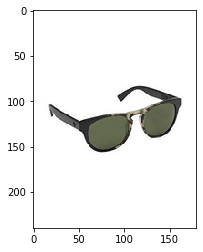

In [ ]:
imgs = glob.glob('/content/new_imgs6/' + '*.jpg')
img_1 = imgs[3]
print(img_1)
x = imageio.imread(img_1)
plt.imshow(x)

/content/new_imgs6/15604.jpg
(240, 180, 3)


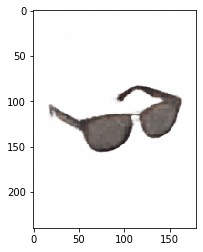

In [ ]:
imgs = glob.glob('/content/new_imgs6/' + '*.jpg')
img_1 = imgs[3]
print(img_1)
x = imageio.imread(img_1)
x = x.astype(np.float32) / 255.0
x = np.reshape(x, [-1, 240, 180, 3])
print(x[0].shape)
out_vae = vae.predict(x)
plt.imshow(out_vae[0])

/content/new_imgs6/96196.jpg
(240, 180, 3)


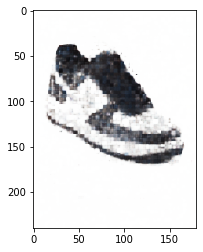

In [ ]:
imgs = glob.glob('/content/new_imgs6/' + '*.jpg')
img_1 = imgs[30]
print(img_1)
x = imageio.imread(img_1)
x = x.astype(np.float32) / 255.0
x = np.reshape(x, [-1, 240, 180, 3])
print(x[0].shape)
out_vae = vae.predict(x)
plt.imshow(out_vae[0])

/content/new_imgs6/21698.jpg
(240, 180, 3)


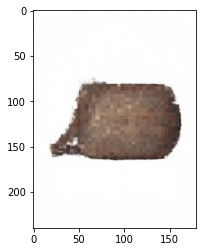

In [ ]:
img_1 = imgs[18002]
print(img_1)
x = imageio.imread(img_1)
x = x.astype(np.float32) / 255.0
x = np.reshape(x, [-1, 240, 180, 3])
print(x[0].shape)
out_vae = vae.predict(x)
plt.imshow(out_vae[0])

In [ ]:
# Encoder funcs
import cv2
import glob, os
import pandas as pd
from PIL import Image
import numpy as np
import imageio
import time
from keras import layers, initializers
import sqlite3

class ImgEncoder():
  input_shape = (240, 180, 3)
  def __init__(self, encoder_name=None, z_dim=16, load=False, encoder_model=None):
    if load:
      # Rebuild
      inputs = Input(shape=self.input_shape, name='encoder_input')
      x = inputs
      kernel_size = 2
      filter_dims = [16, 32, 64]
      for i in range(2):
        filters = filter_dims[i]
        x = Conv2D(filters=filters,
                  kernel_size=kernel_size,
                  strides=2,
                  padding='same')(x)
        x = BatchNormalization()(x)
        x = LeakyReLU(0.1)(x)
      x = Flatten()(x)
      x = Dense(128)(x)
      x = LeakyReLU(0.1)(x)

      z_mean = Dense(z_dim, name='z_mean')(x)
      z_log_var = Dense(z_dim, name='z_log_var',
            kernel_initializer='glorot_normal',
            bias_initializer=initializers.Constant(0.1))(x)

      # use reparameterization trick to push the sampling out as input
      # note that "output_shape" isn't necessary with the TensorFlow backend
      z = Lambda(self.sampling, output_shape=(z_dim,), name='z')([z_mean, z_log_var])

      # instantiate encoder model
      self.encoder = Model(inputs, [z_mean, z_log_var, z], name='encoder')
      self.encoder.load_weights(encoder_name)
    else:
      self.encoder = encoder_model
    epsilon = [-0.3910768, 0.7181829, 1.0971224, 0.86832905, 
                    0.44273394, 0.8981663, -1.8579469, 1.3224537, 
                    1.8836758, -0.91106975, 3.0198312, -2.0472772, 
                    1.8688006, -0.71160805, 0.47197556, -0.567018]
    
    self.epsilon = np.array(epsilon).reshape((z_dim, ))
    self.session = K.get_session()
    print(epsilon)
  
  def sampling(self, args):
    z_mean, z_log_var = args
    batch = K.shape(z_mean)[0]
    dim = K.int_shape(z_mean)[1]
    # by default, random_normal has mean=0 and std=1.0
    epsilon = K.random_normal(shape=(batch, dim))
    return z_mean + K.exp(z_log_var / 2) * epsilon

  # Fixed epsilon sampling, we get z_mean, z_log_var, and z_new for everything
  # Same epsilon sampling for everyone to get discrete z_new
  def encode_sampled(self, input_image):
    # x = imageio.imread(input_image)
    # x = x.astype(np.float32) / 255.0
    x = np.reshape(input_image, [-1, 240, 180, 3])
    z_mean, z_log_var, z = self.encoder.predict(x)
    z_new = z_mean + K.exp(z_log_var / 2) * self.epsilon
    return z_mean, z_log_var, z_new

  def read_imgs_to_np_from_folder(self, start_name, end_name):
    cwd = os.getcwd()
    # os.chdir(img_folder + '/')
    imgs = glob.glob("/content/new_imgs6/" + '*.jpg')
    X = []
    file_names = []
    count = 0

    ids_in_db = self.get_products_from_db()

    for f in imgs:
      name = int(f.replace('.jpg', '').replace('/content/new_imgs6/', ''))

      if name not in ids_in_db:
        x = imageio.imread(f)
        if len(x.shape) == 3 and x.shape[0] == 240 and x.shape[1] == 180 and x.shape[2] == 3:
          x = x.astype(np.float32) / 255.0
          X.append(x)
          count += 1
          
          file_names.append(name)
        if count % 3000 == 0:
          print("Collected ", count)

    X = np.array(X)

    data_ = {
        'name': file_names
    }

    data_fr = pd.DataFrame.from_dict(data_)
    return X, data_fr

  def get_products_from_db(self):
    print("Getting img ids products from db...")
    conn = None
    conn = sqlite3.connect("db.sqlite3")

    cur = conn.cursor()
    sql = '''
            SELECT img_id 
            FROM products
          '''
    prod_df = pd.read_sql_query(sql, conn)
    conn.close()

    return prod_df['img_id'].to_list()

  def encode_all(self, img_data, data_frame):
    z_mean_1 = []
    z_mean_2 = []
    z_mean_3 = []
    z_mean_4 = []
    z_mean_5 = []
    z_mean_6 = []
    z_mean_7 = []
    z_mean_8 = []
    z_mean_9 = []
    z_mean_10 = []
    z_mean_11 = []
    z_mean_12 = []
    z_mean_13 = []
    z_mean_14 = []
    z_mean_15 = []
    z_mean_16 = []
    z_log_var_1 = []
    z_log_var_2 = []
    z_log_var_3 = []
    z_log_var_4 = []
    z_log_var_5 = []
    z_log_var_6 = []
    z_log_var_7 = []
    z_log_var_8 = []
    z_log_var_9 = []
    z_log_var_10 = []
    z_log_var_11 = []
    z_log_var_12 = []
    z_log_var_13 = []
    z_log_var_14 = []
    z_log_var_15 = []
    z_log_var_16 = []
    z_fixed_code_1 = []
    z_fixed_code_2 = []
    z_fixed_code_3 = []
    z_fixed_code_4 = []
    z_fixed_code_5 = []
    z_fixed_code_6 = []
    z_fixed_code_7 = []
    z_fixed_code_8 = []
    z_fixed_code_9 = []
    z_fixed_code_10 = []
    z_fixed_code_11 = []
    z_fixed_code_12 = []
    z_fixed_code_13 = []
    z_fixed_code_14 = []
    z_fixed_code_15 = []
    z_fixed_code_16 = []
    image_names = data_frame['name'].to_list()

    count = 0
    len_img = len(img_data)

    for img_d in img_data:
      start = time.time()
      z_mean, z_log_var, z_fixed_code = self.encode_sampled(img_d)
      z_mean = K.flatten(z_mean).eval(session=self.session)
      z_log_var = K.flatten(z_log_var).eval(session=self.session)
      z_fixed_code = K.flatten(z_fixed_code).eval(session=self.session)

      z_mean_1.append(z_mean[0])
      z_mean_2.append(z_mean[1])
      z_mean_3.append(z_mean[2])
      z_mean_4.append(z_mean[3])
      z_mean_5.append(z_mean[4])
      z_mean_6.append(z_mean[5])
      z_mean_7.append(z_mean[6])
      z_mean_8.append(z_mean[7])
      z_mean_9.append(z_mean[8])
      z_mean_10.append(z_mean[9])
      z_mean_11.append(z_mean[10])
      z_mean_12.append(z_mean[11])
      z_mean_13.append(z_mean[12])
      z_mean_14.append(z_mean[13])
      z_mean_15.append(z_mean[14])
      z_mean_16.append(z_mean[15])
      z_log_var_1.append(z_log_var[0])
      z_log_var_2.append(z_log_var[1])
      z_log_var_3.append(z_log_var[2])
      z_log_var_4.append(z_log_var[3])
      z_log_var_5.append(z_log_var[4])
      z_log_var_6.append(z_log_var[5])
      z_log_var_7.append(z_log_var[6])
      z_log_var_8.append(z_log_var[7])
      z_log_var_9.append(z_log_var[8])
      z_log_var_10.append(z_log_var[9])
      z_log_var_11.append(z_log_var[10])
      z_log_var_12.append(z_log_var[11])
      z_log_var_13.append(z_log_var[12])
      z_log_var_14.append(z_log_var[13])
      z_log_var_15.append(z_log_var[14])
      z_log_var_16.append(z_log_var[15])
      z_fixed_code_1.append(z_fixed_code[0])
      z_fixed_code_2.append(z_fixed_code[1])
      z_fixed_code_3.append(z_fixed_code[2])
      z_fixed_code_4.append(z_fixed_code[3])
      z_fixed_code_5.append(z_fixed_code[4])
      z_fixed_code_6.append(z_fixed_code[5])
      z_fixed_code_7.append(z_fixed_code[6])
      z_fixed_code_8.append(z_fixed_code[7])
      z_fixed_code_9.append(z_fixed_code[8])
      z_fixed_code_10.append(z_fixed_code[9])
      z_fixed_code_11.append(z_fixed_code[10])
      z_fixed_code_12.append(z_fixed_code[11])
      z_fixed_code_13.append(z_fixed_code[12])
      z_fixed_code_14.append(z_fixed_code[13])
      z_fixed_code_15.append(z_fixed_code[14])
      z_fixed_code_16.append(z_fixed_code[15])

      count += 1
      if count % 10 == 0:
        print("Encoded ", count)
        passed = time.time() - start
        remaining = len_img 
        print("Remaining time ", (len_img - count) * (passed / count))
    
    data_ = {
        'name': image_names,
        'z_mean_1' : z_mean_1,
        'z_mean_2' : z_mean_2,
        'z_mean_3' : z_mean_3,
        'z_mean_4' : z_mean_4,
        'z_mean_5' : z_mean_5,
        'z_mean_6' : z_mean_6,
        'z_mean_7' : z_mean_7,
        'z_mean_8' : z_mean_8,
        'z_mean_9' : z_mean_9,
        'z_mean_10' : z_mean_10,
        'z_mean_11' : z_mean_11,
        'z_mean_12' : z_mean_12,
        'z_mean_13' : z_mean_13,
        'z_mean_14' : z_mean_14,
        'z_mean_15' : z_mean_15,
        'z_mean_16' : z_mean_16,
        'z_log_var_1' : z_log_var_1,
        'z_log_var_2' : z_log_var_2,
        'z_log_var_3' : z_log_var_3,
        'z_log_var_4' : z_log_var_4,
        'z_log_var_5' : z_log_var_5,
        'z_log_var_6' : z_log_var_6,
        'z_log_var_7' : z_log_var_7,
        'z_log_var_8' : z_log_var_8,
        'z_log_var_9' : z_log_var_9,
        'z_log_var_10' : z_log_var_10,
        'z_log_var_11' : z_log_var_11,
        'z_log_var_12' : z_log_var_12,
        'z_log_var_13' : z_log_var_13,
        'z_log_var_14' : z_log_var_14,
        'z_log_var_15' : z_log_var_15,
        'z_log_var_16' : z_log_var_16,
        'z_fixed_code_1' : z_fixed_code_1,
        'z_fixed_code_2' : z_fixed_code_2,
        'z_fixed_code_3' : z_fixed_code_3,
        'z_fixed_code_4' : z_fixed_code_4,
        'z_fixed_code_5' : z_fixed_code_5,
        'z_fixed_code_6' : z_fixed_code_6,
        'z_fixed_code_7' : z_fixed_code_7,
        'z_fixed_code_8' : z_fixed_code_8,
        'z_fixed_code_9' : z_fixed_code_9,
        'z_fixed_code_10' : z_fixed_code_10,
        'z_fixed_code_11' : z_fixed_code_11,
        'z_fixed_code_12' : z_fixed_code_12,
        'z_fixed_code_13' : z_fixed_code_13,
        'z_fixed_code_14' : z_fixed_code_14,
        'z_fixed_code_15' : z_fixed_code_15,
        'z_fixed_code_16' : z_fixed_code_16
    }
    
    product_df_code = pd.DataFrame.from_dict(data_)
    return product_df_code
  
  def insert_to_db(self, product_codes_df):
    conn = None
    conn = sqlite3.connect("db.sqlite3")
    try:
      # conn = sqlite3.connect("db.sqlite3")
      cur = conn.cursor()
      z_mean_1 = product_codes_df['z_mean_1'].to_list()
      z_mean_2 = product_codes_df['z_mean_2'].to_list()
      z_mean_3 = product_codes_df['z_mean_3'].to_list()
      z_mean_4 = product_codes_df['z_mean_4'].to_list()
      z_mean_5 = product_codes_df['z_mean_5'].to_list()
      z_mean_6 = product_codes_df['z_mean_6'].to_list()
      z_mean_7 = product_codes_df['z_mean_7'].to_list()
      z_mean_8 = product_codes_df['z_mean_8'].to_list()
      z_mean_9 = product_codes_df['z_mean_9'].to_list()
      z_mean_10 = product_codes_df['z_mean_10'].to_list()
      z_mean_11 = product_codes_df['z_mean_11'].to_list()
      z_mean_12 = product_codes_df['z_mean_12'].to_list()
      z_mean_13 = product_codes_df['z_mean_13'].to_list()
      z_mean_14 = product_codes_df['z_mean_14'].to_list()
      z_mean_15 = product_codes_df['z_mean_15'].to_list()
      z_mean_16 = product_codes_df['z_mean_16'].to_list()
      z_log_var_1 = product_codes_df['z_log_var_1'].to_list()
      z_log_var_2 = product_codes_df['z_log_var_2'].to_list()
      z_log_var_3 = product_codes_df['z_log_var_3'].to_list()
      z_log_var_4 = product_codes_df['z_log_var_4'].to_list()
      z_log_var_5 = product_codes_df['z_log_var_5'].to_list()
      z_log_var_6 = product_codes_df['z_log_var_6'].to_list()
      z_log_var_7 = product_codes_df['z_log_var_7'].to_list()
      z_log_var_8 = product_codes_df['z_log_var_8'].to_list()
      z_log_var_9 = product_codes_df['z_log_var_9'].to_list()
      z_log_var_10 = product_codes_df['z_log_var_10'].to_list()
      z_log_var_11 = product_codes_df['z_log_var_11'].to_list()
      z_log_var_12 = product_codes_df['z_log_var_12'].to_list()
      z_log_var_13 = product_codes_df['z_mean_13'].to_list()
      z_log_var_14 = product_codes_df['z_mean_14'].to_list()
      z_log_var_15 = product_codes_df['z_mean_15'].to_list()
      z_log_var_16 = product_codes_df['z_mean_16'].to_list()
      z_fixed_code_1 = product_codes_df['z_fixed_code_1'].to_list()
      z_fixed_code_2 = product_codes_df['z_fixed_code_2'].to_list()
      z_fixed_code_3 = product_codes_df['z_fixed_code_3'].to_list()
      z_fixed_code_4 = product_codes_df['z_fixed_code_4'].to_list()
      z_fixed_code_5 = product_codes_df['z_fixed_code_5'].to_list()
      z_fixed_code_6 = product_codes_df['z_fixed_code_6'].to_list()
      z_fixed_code_7 = product_codes_df['z_fixed_code_7'].to_list()
      z_fixed_code_8 = product_codes_df['z_fixed_code_8'].to_list()
      z_fixed_code_9 = product_codes_df['z_fixed_code_9'].to_list()
      z_fixed_code_10 = product_codes_df['z_fixed_code_10'].to_list()
      z_fixed_code_11 = product_codes_df['z_fixed_code_11'].to_list()
      z_fixed_code_12 = product_codes_df['z_fixed_code_12'].to_list()
      z_fixed_code_13 = product_codes_df['z_fixed_code_13'].to_list()
      z_fixed_code_14 = product_codes_df['z_fixed_code_14'].to_list()
      z_fixed_code_15 = product_codes_df['z_fixed_code_15'].to_list()
      z_fixed_code_16 = product_codes_df['z_fixed_code_16'].to_list()
      img_id = product_codes_df['name'].to_list()

      for i in range(len(img_id)):
        sql = '''
                INSERT INTO products (img_id, z_mean_1, 
                  z_mean_2, z_mean_3, z_mean_4, 
                  z_mean_5, z_mean_6, z_mean_7, z_mean_8, 
                  z_mean_9, z_mean_10, z_mean_11, z_mean_12, 
                  z_mean_13, z_mean_14, z_mean_15, z_mean_16,
                  z_log_var_1, z_log_var_2, z_log_var_3, z_log_var_4, 
                  z_log_var_5, z_log_var_6, z_log_var_7, z_log_var_8, 
                  z_log_var_9, z_log_var_10, z_log_var_11, z_log_var_12, 
                  z_log_var_13, z_log_var_14, z_log_var_15, z_log_var_16,
                  z_fixed_code_1, z_fixed_code_2, z_fixed_code_3, z_fixed_code_4, 
                  z_fixed_code_5, z_fixed_code_6, z_fixed_code_7, z_fixed_code_8, 
                  z_fixed_code_9, z_fixed_code_10, z_fixed_code_11, z_fixed_code_12, 
                  z_fixed_code_13, z_fixed_code_14, z_fixed_code_15, z_fixed_code_16
                ) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?,
                ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, 
                ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)
              '''
        cur.execute(sql, (img_id[i], z_mean_1[i], z_mean_2[i], z_mean_3[i], 
                  z_mean_4[i], z_mean_5[i], z_mean_6[i], z_mean_7[i], 
                  z_mean_8[i], z_mean_9[i], z_mean_10[i], z_mean_11[i], 
                  z_mean_12[i], z_mean_13[i], z_mean_14[i], z_mean_15[i], z_mean_16[i],
                  z_log_var_1[i], z_log_var_2[i], z_log_var_3[i], z_log_var_4[i], 
                  z_log_var_5[i], z_log_var_6[i], z_log_var_7[i], z_log_var_8[i], 
                  z_log_var_9[i], z_log_var_10[i], z_log_var_11[i], z_log_var_12[i], 
                  z_log_var_13[i], z_log_var_14[i], z_log_var_15[i], z_log_var_16[i],
                  z_fixed_code_1[i], z_fixed_code_2[i], z_fixed_code_3[i], z_fixed_code_4[i], 
                  z_fixed_code_5[i], z_fixed_code_6[i], z_fixed_code_7[i], z_fixed_code_8[i], 
                  z_fixed_code_9[i], z_fixed_code_10[i], z_fixed_code_11[i], z_fixed_code_12[i], 
                  z_fixed_code_13[i], z_fixed_code_14[i], z_fixed_code_15[i], z_fixed_code_16[i]
                )
        )

        if i % 1000 == 0:
          print("Saved at ", i)
          conn.commit()
      conn.commit()
    except Exception as e:
      print(str(e))
    conn.close()
    

In [ ]:
images_encoder = ImgEncoder(encoder_name="/content/drive/My Drive/rerun/encoder_binary_cross_adam_epoch_only_relu_200.h5", load=True, encoder_model=None)
x_data, data_fr = images_encoder.read_imgs_to_np_from_folder(0, 200000)
# print("Len ", len(x_data))
product_codes_df = images_encoder.encode_all(x_data, data_fr)
images_encoder.insert_to_db(product_codes_df)
# !chmod 777 '/content/drive/My Drive/rerun/'

# Run1 567














[-0.3910768, 0.7181829, 1.0971224, 0.86832905, 0.44273394, 0.8981663, -1.8579469, 1.3224537, 1.8836758, -0.91106975, 3.0198312, -2.0472772, 1.8688006, -0.71160805, 0.47197556, -0.567018]
Getting img ids products from db...
Encoded  10
Remaining time  4.947161674499512
Encoded  20
Remaining time  3.1872408390045166
Encoded  30
Remaining time  2.2704339027404785
Encoded  40
Remaining time  1.8576610088348389
Encoded  50
Remaining time  1.632960605621338
Encoded  60
Remaining time  1.5146398544311523
Encoded  70
Remaining time  1.3489231041499545
Encoded  80
Remaining time  1.3061487674713135
Encoded  90
Remaining time  1.2688942750295003
Encoded  100
Remaining time  1.4548283576965333
Encoded  110
Remaining time  1.1859895966269753
Encoded  120
Remaining time  1.1341948509216309
Encoded  130
Remaining time  1.1778700718512902
Encoded  140
Remaining time  1.0926871299743652
Encoded  150
Remaining time  1.051155996322632
Encoded  160
Remaining time  1.135040521621704
Encoded  